# Finite Difference Method for Black-Scholes PDE

In [1]:
import numpy as np
from scipy.stats import norm
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import splu
from scipy.sparse.linalg import spsolve
from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt

In [2]:
S = 100.
K = 100.
T = 1.
r = 0.02
sigma = 0.15

## Analytical Solution

In [3]:
def bsm_price(S, K, T, r, sigma):
    """
    Calculate the price of a European put using BSM model
    """
    d_1 = (np.log(S/K) + (r+sigma**2/2)*T) / (sigma*np.sqrt(T))
    d_2 = d_1 - sigma*np.sqrt(T)
    
    return K*np.exp(-r*T)*norm.cdf(-d_2) - S*norm.cdf(-d_1)

In [4]:
bsm_price(S, K, T, r, sigma)

4.9817089752296795

## Finite Difference

For a European call or put on an underlying stock paying no dividends, the Black-Scholes equation is:

$$
\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^2S^2\frac{\partial^2V}{\partial S^2}+rS\frac{\partial V}{\partial S}-rV=0
$$

with the following conditions:

$$
V(0,t)=Ke^{-r(T-t)},\ V(S_\max,t)=0,\ 0\leq t\leq T\\
V(S,T)=\max(K-S,0),\ 0\leq S\leq S_\max
$$

### Implicit Method

In [5]:
def fd_implicit_price(S0, K, T, r, sigma, show_figure=False):
    """
    Calculate the price of a European put option using finite difference (implicit)
    """
    # mesh setup
    N = 100 # number of steps in \tau
    J = 100 # number of steps in S
    S_max = 3*K
    S_min = 0
    dt = T/N
    dS = (S_max-S_min)/J
    t = np.arange(0, N+1)*dt
    S = np.arange(0, J+1)*dS + S_min
    V = np.zeros((N+1, J+1))

    # Dirichlet condition
    for j in range(J+1):
        V[0, j] = np.maximum(K-S[j], 0)
    for n in range(N+1):
        V[n, 0] = K * np.exp(-r*t[n])
        V[n, J] = 0
    
    def alpha(j):
        return dt/2*(r*j-sigma**2*j**2)
    def beta(j):
        return dt*(r+sigma**2*j**2)
    def gamma(j):
        return -dt/2*(r*j+sigma**2*j**2)
    
    # solve the system of linear equations Av=b
    for n in range(1, N+1):
        A = np.zeros((J-1, J-1))
        
        # Neumann condition
        A[0, 0] = 1 + beta(1) + 2*alpha(1)
        A[0, 1] = gamma(1) - alpha(1)
        A[J-2, -2] = alpha(J-1) - gamma(J-1)
        A[J-2, -1] = 1 + beta(J-1) + 2*gamma(J-1)
        
        for j in range(1, J-2):
            A[j, j-1] = alpha(j+1)
            A[j, j] = 1 + beta(j+1)
            A[j, j+1] = gamma(j+1)
        A = csr_matrix(A)
        
        b = np.zeros(J-1)
        b = V[n-1, 1:J]
        
        V[n, 1:J] = splu(A).solve(b)
    
    # plot the grid surface
    if show_figure==True:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        X, Y = np.meshgrid(S, t)
        ax.plot_surface(X, Y, V)
        ax.set_xlabel('S')
        ax.set_ylabel('τ')
        ax.set_zlabel('V')
        ax.set_title('Finite Difference (Implicit)')
        plt.show()
    
    # use a natural cubic spline to interpolate the result
    cs = CubicSpline(S, V[N], bc_type='natural')
    return cs(S0).item(0)

/Users/cyao/miniconda3/envs/py4fin/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


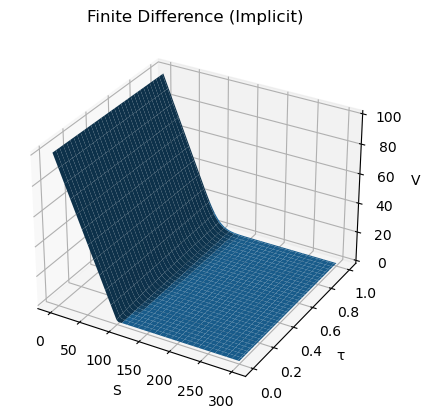

4.9705868540889675

In [6]:
fd_implicit_price(S, K, T, r, sigma, show_figure=True)

### Crank-Nicolson Method

In [7]:
def fd_crank_nicolson_price(S0, K, T, r, sigma, show_figure=False):
    """
    Calculate the price of a European put option using finite difference (Crank-Nicolson)
    """
    # mesh setup
    N = 100 # number of steps in \tau
    J = 100 # number of steps in S
    S_max = 3*K
    S_min = 0
    dt = T/N
    dS = (S_max-S_min)/J
    t = np.arange(0, N+1)*dt
    S = np.arange(0, J+1)*dS + S_min
    V = np.zeros((N+1, J+1))

    # Dirichlet condition
    for j in range(J+1):
        V[0, j] = np.maximum(K-S[j], 0)
    for n in range(N+1):
        V[n, 0] = K * np.exp(-r*t[n])
        V[n, J] = 0
    
    def alpha(j):
        return dt/4*(r*j-sigma**2*j**2)
    def beta(j):
        return dt/2*(sigma**2*j**2+r)
    def gamma(j):
        return -dt/4*(r*j+sigma**2*j**2)
    
    # solve the system of linear equations
    for n in range(1, N+1):
        A = np.zeros((J-1, J-1))
        A_ = np.zeros((J-1, J-1))
        # Neumann condition
        A[0, 0] = 1 + beta(1) + 2*alpha(1)
        A[0, 1] = gamma(1) - alpha(1)
        A[J-2, -2] = alpha(J-1) - gamma(J-1)
        A[J-2, -1] = 1 + beta(J-1) + 2*gamma(J-1)
        A_[0, 0] = 1 - beta(1) - 2*alpha(1)
        A_[0, 1] = -gamma(1) + alpha(1)
        A_[J-2, -2] = -alpha(J-1) + gamma(J-1)
        A_[J-2, -1] = 1 - beta(J-1) - 2*gamma(J-1)
             
        for j in range(1, J-2):
            A[j, j-1] = alpha(j+1)
            A[j, j] = 1 + beta(j+1)
            A[j, j+1] = gamma(j+1)
            A_[j, j-1] = -alpha(j+1)
            A_[j, j] = 1 - beta(j+1)
            A_[j, j+1] = -gamma(j+1)
        
        A = csr_matrix(A)
        b = np.matmul(A_, V[n-1, 1:J])
        V[n, 1:J] = splu(A).solve(b)
    
    # plot the grid surface
    if show_figure==True:
        fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
        X, Y = np.meshgrid(S, t)
        ax.plot_surface(X, Y, V)
        ax.set_xlabel('S')
        ax.set_ylabel('τ')
        ax.set_zlabel('V')
        ax.set_title('Finite Difference (Crank-Nicolson)')
        plt.show()
    
    # use a natural cubic spline to interpolate the result
    cs = CubicSpline(S, V[N], bc_type='natural')
    return cs(S0).item(0)

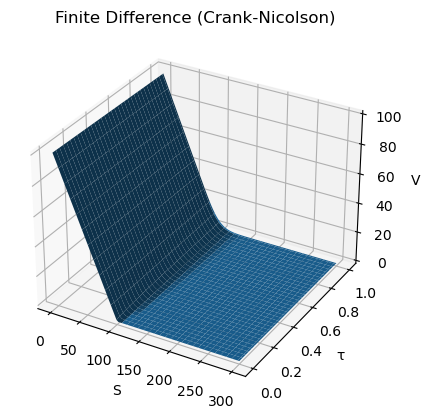

4.9780435370304525

In [8]:
fd_crank_nicolson_price(S, K, T, r, sigma, show_figure=True)

## Comparison

In [9]:
S = 100.
K_ = [60, 70, 80, 90, 100, 110, 120, 130, 140]
T = 1
r = 0.02
sigma_ = [0.15, 0.30, 0.50]

In [10]:
V_bsm = np.zeros((len(K_), len(sigma_)))
V_fd_implicit = np.zeros((len(K_), len(sigma_)))
V_fd_crank_nicolson = np.zeros((len(K_), len(sigma_)))

for i in range(len(K_)):
    for j in range(len(sigma_)):
        V_bsm[i, j] = bsm_price(S, K_[i], T, r, sigma_[j])
        V_fd_implicit[i, j] = fd_implicit_price(S, K_[i], T, r, sigma_[j])
        V_fd_crank_nicolson[i, j] = fd_crank_nicolson_price(S, K_[i], T, r, sigma_[j])

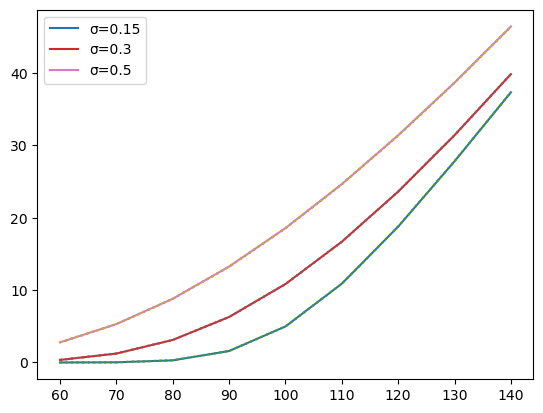

In [11]:
for i in range(len(sigma_)):
    plt.plot(K_, V_bsm[:, i])
    plt.plot(K_, V_fd_implicit[:, i], ':', label='_nolegend_')
    plt.plot(K_, V_fd_crank_nicolson[:, i], ':', label='_nolegend_')
plt.legend([f'σ={sigma_[0]}', f'σ={sigma_[1]}', f'σ={sigma_[2]}'])
plt.show()